In [1]:
'''
    Author: A.Shrikant
'''

'\n    Author: A.Shrikant\n'

In [2]:
# Attributes Information:

# step - maps a unit of time in the real world. In this case 1 step is 1 hour 
# of time. Total steps 744 (30 days simulation).

# type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

# amount - amount of the transaction in local currency.

# nameOrig - customer who started the transaction

# oldbalanceOrg - initial balance before the transaction

# newbalanceOrig - new balance after the transaction.

# nameDest - customer who is the recipient of the transaction

# oldbalanceDest - initial balance recipient before the transaction. Note that 
# there is not information for customers that start with M (Merchants).

# newbalanceDest - new balance recipient after the transaction. Note that there 
# is not information for customers that start with M (Merchants).

# isFraud - This is the transactions made by the fraudulent agents inside the 
# simulation. In this specific dataset the fraudulent behavior of the agents 
# aims to profit by taking control or customers accounts and try to empty the 
# funds by transferring to another account and then cashing out of the system.

# isFlaggedFraud - The business model aims to control massive transfers from one 
# account to another and flags illegal attempts. An illegal attempt in this dataset 
# is an attempt to transfer more than 200.000 in a single transaction.

# URL to download the Paysim dataset: https://www.kaggle.com/datasets/ealaxi/paysim1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score

In [2]:
df1 = pd.read_csv('Money Laundering.csv')

In [3]:
df1.shape

(6362620, 11)

In [4]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df1.duplicated().sum()

0

In [7]:
df1.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### No duplicate and missing values are there.

### Analysing transactions using 'type' variable:

In [8]:
type_dist_ser = df1['type'].value_counts()
type_dist_ser

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [9]:
pd.Series(type_dist_ser/type_dist_ser.sum(), name='proportion')

type
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: proportion, dtype: float64

In [10]:
is_fraud_mask = df1['isFraud'] == 1
is_not_fraud_mask = ~ is_fraud_mask

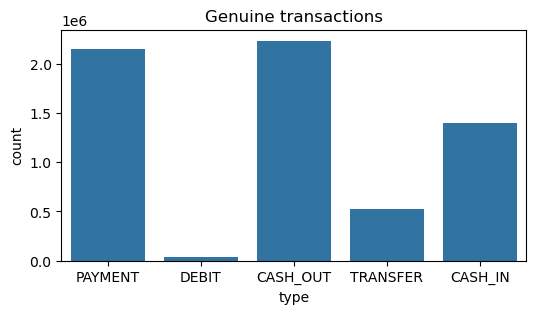

In [11]:
plt.figure(figsize=(6,3))
sns.countplot(df1[is_not_fraud_mask], x='type')
plt.title('Genuine transactions')
plt.show()

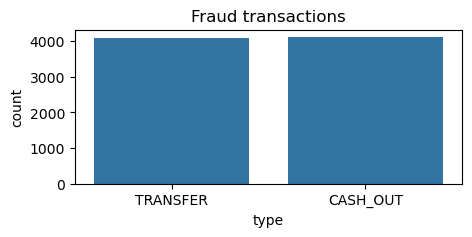

In [12]:
plt.figure(figsize=(5,2))
sns.countplot(df1[is_fraud_mask], x='type')
plt.title('Fraud transactions')
plt.show()

### Analysing transactions using 'isFraud' variable:

In [13]:
isFraud_dist_ser = df1['isFraud'].value_counts()
isFraud_dist_ser

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [14]:
pd.Series(isFraud_dist_ser/isFraud_dist_ser.sum(), name='proportion')

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

### Inference: Almost 99.88% of transactions are Genuine and only 0.13% of transactions are Fraudulent. This implies a highly imbalanced dataset.

### Analysing transactions using 'isFlaggedFraud' variable:

In [15]:
df1['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [16]:
df1[((df1['amount'] >= 200000) & (df1['type'] == 'TRANSFER'))]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
82,1,TRANSFER,224606.64,C873175411,0.00,0.0,C766572210,354678.92,0.00,0,0
84,1,TRANSFER,379856.23,C1449772539,0.00,0.0,C1590550415,900180.00,19169204.93,0,0
85,1,TRANSFER,1505626.01,C926859124,0.00,0.0,C665576141,29031.00,5515763.34,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362608,742,TRANSFER,258355.42,C1226129332,258355.42,0.0,C1744173808,0.00,0.00,1,0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0


In [17]:
df1[df1['isFlaggedFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


### Inference: Dataset show that not all transactions with amount > 200000 and type=TRANSFER have 'isFraudFlagged' 1. This is incontrary to what the meta data says for 'isFraudFlagged'.

### Analysing transactions using variables 'nameOrig' and 'nameDest':

In [18]:
df1['nameOrig'].unique().size

6353307

In [19]:
df1['nameDest'].unique().size

2722362

In [20]:
df1[df1['nameOrig']==df1['nameDest']]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [21]:
customers_in_orig_mask = df1['nameOrig'].str.startswith('C')
customers_in_orig_mask.sum()

6362620

In [22]:
merchants_in_orig_mask = ~ customers_in_orig_mask
merchants_in_orig_mask.sum()

0

In [23]:
customers_in_dest_mask = df1['nameDest'].str.startswith('C')
customers_in_dest_mask.sum()

4211125

In [24]:
merchants_in_dest_mask = ~ customers_in_dest_mask
df1[merchants_in_dest_mask]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362312,718,PAYMENT,8178.01,C1213413071,11742.0,3563.99,M1112540487,0.0,0.0,0,0
6362314,718,PAYMENT,17841.23,C1045048098,10182.0,0.00,M1878955882,0.0,0.0,0,0
6362316,718,PAYMENT,1022.91,C1203084509,12.0,0.00,M675916850,0.0,0.0,0,0
6362318,718,PAYMENT,4109.57,C673558958,5521.0,1411.43,M1126011651,0.0,0.0,0,0


In [25]:
TT = df1.shape[0]
N_CC_T = customers_in_dest_mask.sum()
N_CM_T = TT - N_CC_T


print(f'Percentage of CC_T: {N_CC_T/TT}')
print(f'Percentage of CM_T: {N_CM_T/TT}')

Percentage of CC_T: 0.6618539218120837
Percentage of CM_T: 0.3381460781879163


### Inference: 2/3 of the transactions are CC_T and 1/3 are CM_T.

In [26]:
N_F_CC_T = (customers_in_dest_mask & is_fraud_mask).sum()
N_G_CC_T = N_CC_T - N_F_CC_T

N_F_CM_T = (merchants_in_dest_mask & is_fraud_mask).sum()
N_G_CM_T = N_CM_T - N_F_CM_T

print(f'Percentage of fraud transactions in CC_T: {N_F_CC_T/N_CC_T}')
print(f'Percentage of genuine transactions in CC_T: {N_G_CC_T/N_CC_T}')

print(f'Percentage of fraud transactions in CM_T: {N_F_CM_T/N_CM_T}')
print(f'Percentage of genuine transactions in CM_T: {N_G_CM_T/N_CM_T}')

Percentage of fraud transactions in CC_T: 0.001950310190269821
Percentage of genuine transactions in CC_T: 0.9980496898097302
Percentage of fraud transactions in CM_T: 0.0
Percentage of genuine transactions in CM_T: 1.0


### Inference: All the fraud cases mentioned in the dataset occurred in CC_T and no fraud occurred in CM_T.

In [27]:
cols_to_remove_1 = ['nameOrig', 'nameDest', 'isFlaggedFraud']
df2 = df1.drop(columns=cols_to_remove_1)
df2['is_CM_T'] = np.where(merchants_in_dest_mask, 1, 0)

In [28]:
df2

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_CM_T
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,1
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,1
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,1
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


### Analysing the balance of both sender's and recipient's account:

In [29]:
orig_bal_should_decrease_mask = df2['type'].isin(['TRANSFER', 'PAYMENT', 'CASH_OUT', 'DEBIT'])
orig_bal_mismatch_after_debit_mask = (orig_bal_should_decrease_mask &
                                      (abs(df2['oldbalanceOrg'] - df2['newbalanceOrig'] - df2['amount']) > 0.02))
orig_bal_match_after_debit_mask = (orig_bal_should_decrease_mask &
                                   (abs(df2['oldbalanceOrg'] - df2['newbalanceOrig'] - df2['amount']) <= 0.02))

dest_bal_mismatch_after_debit_mask = (orig_bal_should_decrease_mask &
                                         (abs(df2['newbalanceDest'] - df2['oldbalanceDest'] - df2['amount']) > 0.02))
dest_bal_match_after_debit_mask = (orig_bal_should_decrease_mask &
                                   (abs(df2['newbalanceDest'] - df2['oldbalanceDest'] - df2['amount']) <= 0.02))

orig_bal_should_increase_mask = df2['type'].isin(['CASH_IN'])
orig_bal_mismatch_after_credit_mask = (orig_bal_should_increase_mask &
                                       (abs(df2['newbalanceOrig'] - df2['oldbalanceOrg'] - df2['amount']) > 0.02))
orig_bal_match_after_credit_mask = (orig_bal_should_increase_mask &
                                    (abs(df2['newbalanceOrig'] - df2['oldbalanceOrg'] - df2['amount']) <= 0.02))

dest_bal_mismatch_after_credit_mask = (orig_bal_should_increase_mask &
                                       (abs(df2['oldbalanceDest'] - df2['newbalanceDest'] - df2['amount']) > 0.02))
dest_bal_match_after_credit_mask = (orig_bal_should_increase_mask &
                                    (abs(df2['oldbalanceDest'] - df2['newbalanceDest'] - df2['amount']) <= 0.02))

In [30]:
orig_bal_mismatch_after_debit_count = orig_bal_mismatch_after_debit_mask.sum()
orig_bal_match_after_debit_count = orig_bal_match_after_debit_mask.sum()

dest_bal_mismatch_after_debit_count = dest_bal_mismatch_after_debit_mask.sum()
dest_bal_match_after_debit_count = dest_bal_match_after_debit_mask.sum()

print(f'orig_bal_mismatch_after_debit_count: {orig_bal_mismatch_after_debit_count}')
print(f'orig_bal_match_after_debit_count: {orig_bal_match_after_debit_count}')
print(f'dest_bal_mismatch_after_debit_count: {dest_bal_mismatch_after_debit_count}')
print(f'dest_bal_match_after_debit_count: {dest_bal_match_after_debit_count}')

orig_bal_mismatch_after_debit_count: 3601560
orig_bal_match_after_debit_count: 1361776
dest_bal_mismatch_after_debit_count: 2424660
dest_bal_match_after_debit_count: 2538676


In [31]:
orig_bal_mismatch_after_credit_count = orig_bal_mismatch_after_credit_mask.sum()
orig_bal_match_after_credit_count = orig_bal_match_after_credit_mask.sum()

dest_bal_mismatch_after_credit_count = dest_bal_mismatch_after_credit_mask.sum()
dest_bal_match_after_credit_count = dest_bal_match_after_credit_mask.sum()

print(f'orig_bal_mismatch_after_credit_count: {orig_bal_mismatch_after_credit_count}')
print(f'orig_bal_match_after_credit_count: {orig_bal_match_after_credit_count}')
print(f'dest_bal_mismatch_after_credit_count: {dest_bal_mismatch_after_credit_count}')
print(f'dest_bal_match_after_credit_count: {dest_bal_match_after_credit_count}')

orig_bal_mismatch_after_credit_count: 33
orig_bal_match_after_credit_count: 1399251
dest_bal_mismatch_after_credit_count: 367245
dest_bal_match_after_credit_count: 1032039


In [32]:
(orig_bal_match_after_debit_mask & dest_bal_match_after_debit_mask).sum()

279804

In [33]:
(orig_bal_match_after_credit_mask & dest_bal_match_after_credit_mask).sum()

1032039

In [34]:
(orig_bal_mismatch_after_debit_mask & dest_bal_mismatch_after_debit_mask).sum()

1342688

In [35]:
(orig_bal_mismatch_after_credit_mask & dest_bal_mismatch_after_credit_mask).sum()

33

### Inference: The simulation is not taking into account of the data integrity constraint i.e. in the dataset the rule amount deducted must be equal to amount added is not followed.

In [36]:
((df2['oldbalanceOrg'] == df2['newbalanceOrig'])).sum()

2089037

In [37]:
((df2['oldbalanceDest'] == df2['newbalanceDest'])).sum()

2317292

In [38]:
orig_same_old_and_new_bal_during_bal_mismatch_debit = ((df2['oldbalanceOrg'] == df2['newbalanceOrig']) & 
                                                       orig_bal_mismatch_after_debit_mask).sum()
orig_same_old_and_new_bal_during_bal_mismatch_credit = ((df2['oldbalanceOrg'] == df2['newbalanceOrig']) & 
                                                        orig_bal_mismatch_after_credit_mask).sum()

dest_same_old_and_new_bal_during_bal_mismatch_debit = ((df2['oldbalanceDest'] == df2['newbalanceDest']) & 
                                                       dest_bal_mismatch_after_debit_mask).sum()
dest_same_old_and_new_bal_during_bal_mismatch_credit = ((df2['oldbalanceDest'] == df2['newbalanceDest']) & 
                                                        dest_bal_mismatch_after_credit_mask).sum()

print(f'orig_same_old_and_new_bal_during_bal_mismatch_debit: {orig_same_old_and_new_bal_during_bal_mismatch_debit}')
print(f'orig_same_old_and_new_bal_during_bal_mismatch_credit: {orig_same_old_and_new_bal_during_bal_mismatch_credit}')
print(f'dest_same_old_and_new_bal_during_bal_mismatch_debit: {dest_same_old_and_new_bal_during_bal_mismatch_debit}')
print(f'dest_same_old_and_new_bal_during_bal_mismatch_credit: {dest_same_old_and_new_bal_during_bal_mismatch_credit}')

orig_same_old_and_new_bal_during_bal_mismatch_debit: 2088985
orig_same_old_and_new_bal_during_bal_mismatch_credit: 33
dest_same_old_and_new_bal_during_bal_mismatch_debit: 2157268
dest_same_old_and_new_bal_during_bal_mismatch_credit: 160005


In [39]:
orig_same_old_and_new_bal_during_bal_match_debit = ((df2['oldbalanceOrg'] == df2['newbalanceOrig']) & 
                                                       orig_bal_match_after_debit_mask)
orig_same_old_and_new_bal_during_bal_match_credit = ((df2['oldbalanceOrg'] == df2['newbalanceOrig']) & 
                                                        orig_bal_match_after_credit_mask)

dest_same_old_and_new_bal_during_bal_match_debit = ((df2['oldbalanceDest'] == df2['newbalanceDest']) & 
                                                       dest_bal_match_after_debit_mask)
dest_same_old_and_new_bal_during_bal_match_credit = ((df2['oldbalanceDest'] == df2['newbalanceDest']) & 
                                                        dest_bal_match_after_credit_mask)

print(f'orig_same_old_and_new_bal_during_bal_match_debit: {orig_same_old_and_new_bal_during_bal_match_debit.sum()}')
print(f'orig_same_old_and_new_bal_during_bal_match_credit: {orig_same_old_and_new_bal_during_bal_match_credit.sum()}')
print(f'dest_same_old_and_new_bal_during_bal_match_debit: {dest_same_old_and_new_bal_during_bal_match_debit.sum()}')
print(f'dest_same_old_and_new_bal_during_bal_match_credit: {dest_same_old_and_new_bal_during_bal_match_credit.sum()}')

orig_same_old_and_new_bal_during_bal_match_debit: 19
orig_same_old_and_new_bal_during_bal_match_credit: 0
dest_same_old_and_new_bal_during_bal_match_debit: 19
dest_same_old_and_new_bal_during_bal_match_credit: 0


In [40]:
df2['err_in_bal_org'] = np.where(orig_bal_should_increase_mask, df2['newbalanceOrig'] - df2['oldbalanceOrg'] 
                                 - df2['amount'], df2['oldbalanceOrg'] - df2['newbalanceOrig'] - df2['amount'])
df2['err_in_bal_dest'] = np.where(orig_bal_should_increase_mask, df2['oldbalanceDest'] - df2['newbalanceDest'] 
                                  - df2['amount'], df2['newbalanceDest'] - df2['oldbalanceDest'] - df2['amount'])

In [41]:
df2

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_CM_T,err_in_bal_org,err_in_bal_dest
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,1,1.455192e-11,-9.839640e+03
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,1,-1.136868e-12,-1.864280e+03
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,0.000000e+00,-1.810000e+02
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,0.000000e+00,-2.136300e+04
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,1,0.000000e+00,-1.166814e+04
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,0.000000e+00,0.000000e+00
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0.000000e+00,-6.311409e+06
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0.000000e+00,-1.000000e-02
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,0.000000e+00,-8.500025e+05


In [42]:
df2[['err_in_bal_org', 'err_in_bal_dest']].describe()

,err_in_bal_org,err_in_bal_dest
count,6.362620e+06,6.362620e+06
mean,-1.267959e+05,-2.427970e+03
std,5.943125e+05,4.116677e+05
min,-9.244552e+07,-5.695142e+07
25%,-1.145037e+05,-8.493712e+03
50%,-5.797990e+03,-1.746230e-10
75%,0.000000e+00,0.000000e+00
max,1.000001e-02,7.588573e+07


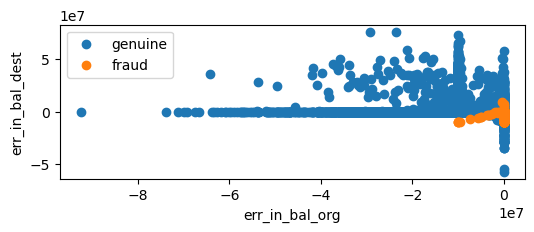

In [43]:
plt.figure(figsize=(6,2))
plt.scatter(x=df2[is_not_fraud_mask]['err_in_bal_org'], y=df2[is_not_fraud_mask]['err_in_bal_dest'], 
            label='genuine')
plt.scatter(x=df2[is_fraud_mask]['err_in_bal_org'], y=df2[is_fraud_mask]['err_in_bal_dest'], 
            label='fraud')
plt.legend()
plt.xlabel('err_in_bal_org')
plt.ylabel('err_in_bal_dest')
plt.show()

### Analysing transactions using the 'step' variable:

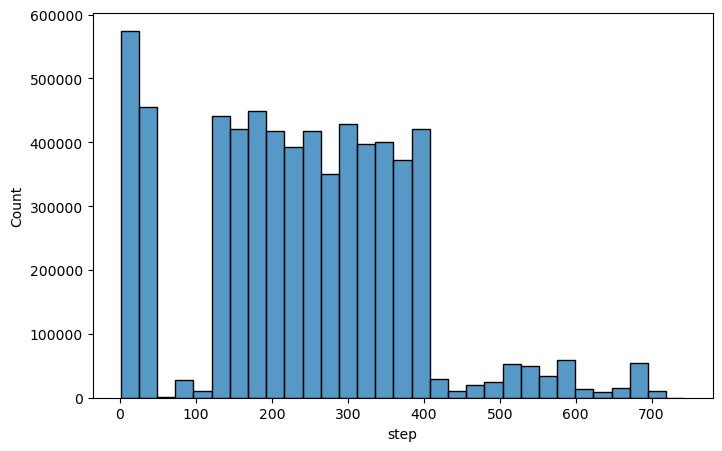

In [44]:
plt.figure(figsize=(8,5))
sns.histplot(df2, x='step', binwidth=24)
plt.show()

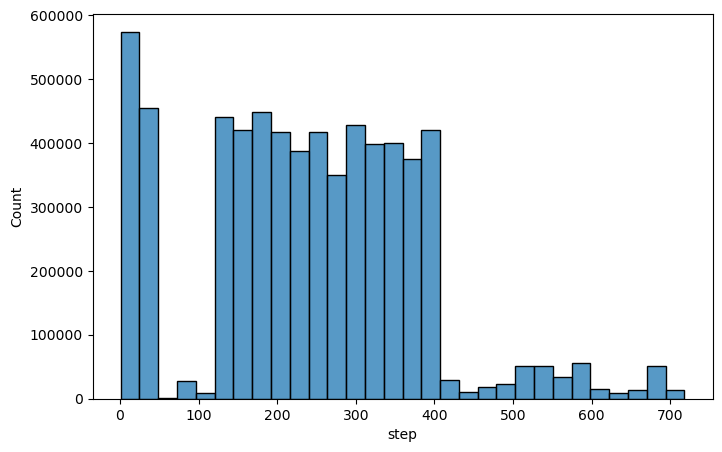

In [45]:
plt.figure(figsize=(8,5))
sns.histplot(df2[is_not_fraud_mask], x='step', binwidth=24)
plt.show()

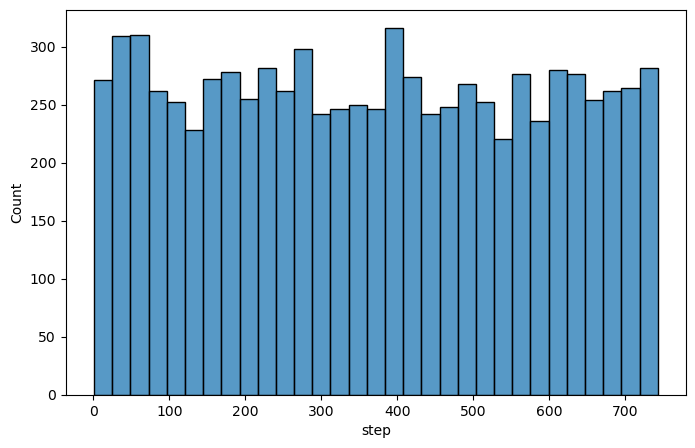

In [46]:
plt.figure(figsize=(8,5))
sns.histplot(df2[is_fraud_mask], x='step', binwidth=24)
plt.show()

### Inference: Most of the genuine transactions are done on days 1-2 and days 6-17 of the month. Whereas the fraud transactions are done uniformly across all days of the month.

In [47]:
df2['hour_of_day'] = df2['step'] % 24
df2

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_CM_T,err_in_bal_org,err_in_bal_dest,hour_of_day
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,1,1.455192e-11,-9.839640e+03,1
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,1,-1.136868e-12,-1.864280e+03,1
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,0.000000e+00,-1.810000e+02,1
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,0.000000e+00,-2.136300e+04,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,1,0.000000e+00,-1.166814e+04,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,0.000000e+00,0.000000e+00,23
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0.000000e+00,-6.311409e+06,23
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0.000000e+00,-1.000000e-02,23
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,0.000000e+00,-8.500025e+05,23


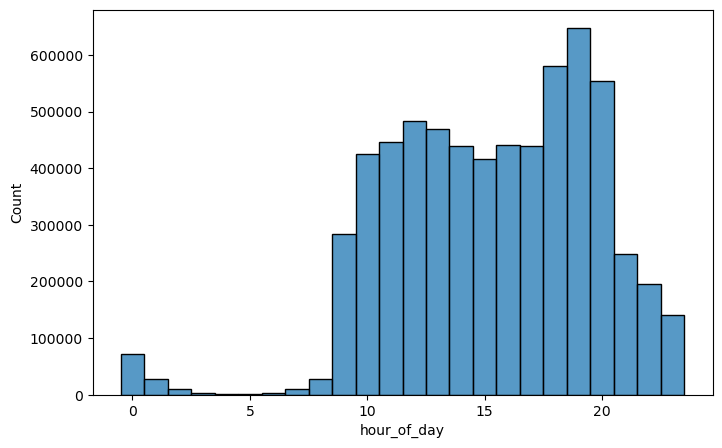

In [48]:
plt.figure(figsize=(8,5))
sns.histplot(df2, x='hour_of_day', discrete=True)
plt.show()

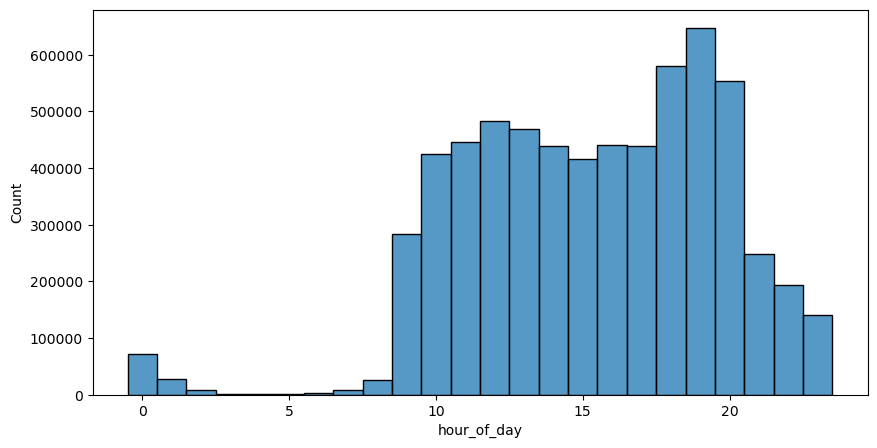

In [49]:
plt.figure(figsize=(10,5))
sns.histplot(df2[is_not_fraud_mask], x='hour_of_day', discrete=True)
plt.show()

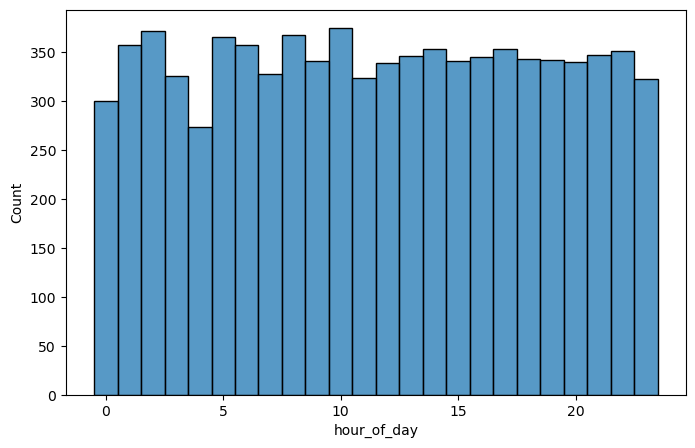

In [50]:
plt.figure(figsize=(8,5))
sns.histplot(df2[is_fraud_mask], x='hour_of_day', discrete=True)
plt.show()

### Inference: Most of the genuine transactions are done on hour of the day 9-23. Whereas the fraud transactions are done uniformly across all hours of the day.

In [51]:
amount_by_type_df = df2.groupby(by=['isFraud', 'type'])[['amount']].sum().reset_index()
amount_by_type_df

,isFraud,type,amount
0,0,CASH_IN,2.363674e+11
1,0,CASH_OUT,3.884238e+11
2,0,DEBIT,2.271992e+08
3,0,PAYMENT,2.809337e+10
4,0,TRANSFER,4.792248e+11
5,1,CASH_OUT,5.989202e+09
6,1,TRANSFER,6.067213e+09


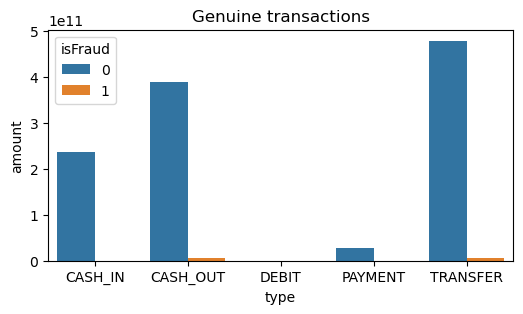

In [52]:
plt.figure(figsize=(6,3))
sns.barplot(data=amount_by_type_df, y='amount', x='type', hue='isFraud')
plt.title('Genuine transactions')
plt.show()

In [53]:
exclude_cols_1 = ['type', 'step', 'isFraud', 'is_CM_T', 'hour_of_day']
selected_columns = [col_name for col_name in df2.columns.values if col_name not in exclude_cols_1]
selected_columns

['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'err_in_bal_org',
 'err_in_bal_dest']

In [54]:
df2[selected_columns].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,err_in_bal_org,err_in_bal_dest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,-1.267959e+05,-2.427970e+03
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,5.943125e+05,4.116677e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.244552e+07,-5.695142e+07
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.145037e+05,-8.493712e+03
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,-5.797990e+03,-1.746230e-10
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000001e-02,7.588573e+07


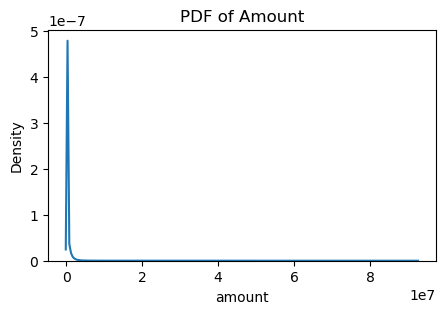

In [55]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2['amount'])
plt.title('PDF of Amount')
plt.show()

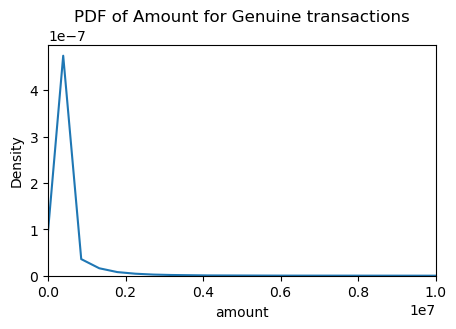

In [56]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_not_fraud_mask], x='amount')
plt.title('PDF of Amount for Genuine transactions')
plt.xlim([-1000,10000000])
plt.show()

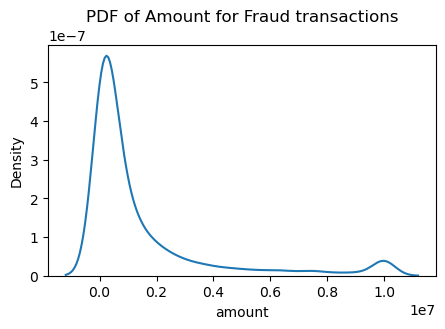

In [57]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_fraud_mask], x='amount')
plt.title('PDF of Amount for Fraud transactions')
plt.show()

### The distribution for 'amount' is not normally distributed.

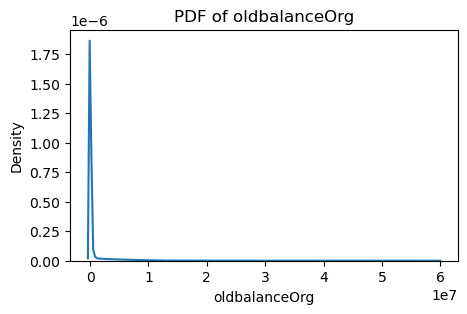

In [58]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2['oldbalanceOrg'])
plt.title('PDF of oldbalanceOrg')
plt.show()

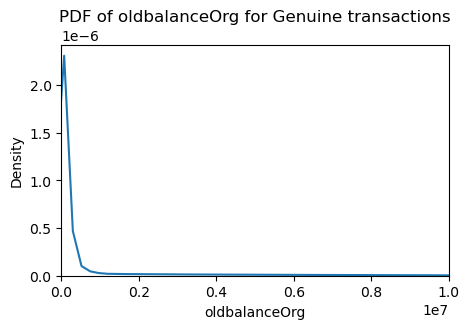

In [59]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_not_fraud_mask], x='oldbalanceOrg')
plt.title('PDF of oldbalanceOrg for Genuine transactions')
plt.xlim([-1000,10000000])
plt.show()

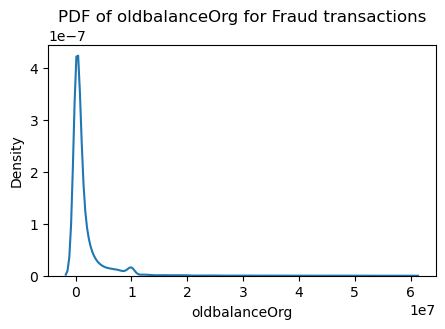

In [60]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_fraud_mask], x='oldbalanceOrg')
plt.title('PDF of oldbalanceOrg for Fraud transactions')
plt.show()

### The distribution for 'oldbalanceOrg' is not normally distributed.

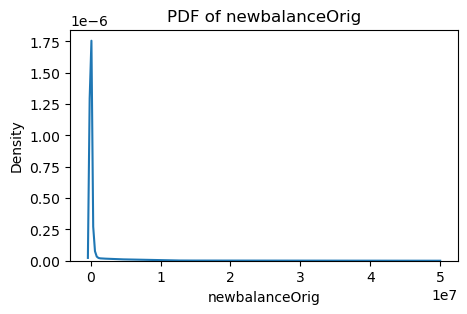

In [61]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2['newbalanceOrig'])
plt.title('PDF of newbalanceOrig')
plt.show()

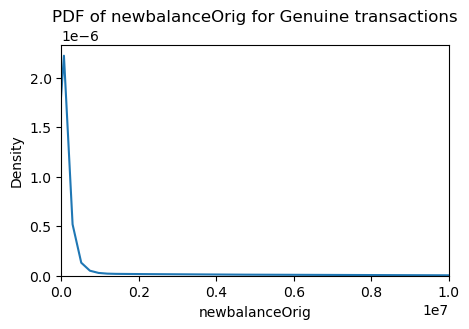

In [62]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_not_fraud_mask], x='newbalanceOrig')
plt.title('PDF of newbalanceOrig for Genuine transactions')
plt.xlim([-1000,10000000])
plt.show()

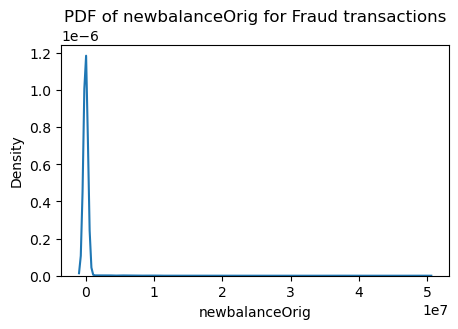

In [63]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_fraud_mask], x='newbalanceOrig')
plt.title('PDF of newbalanceOrig for Fraud transactions')
plt.show()

### The distribution for 'newbalanceOrig' is not normally distributed.

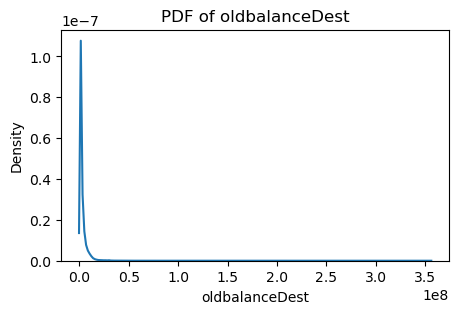

In [64]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2['oldbalanceDest'])
plt.title('PDF of oldbalanceDest')
plt.show()

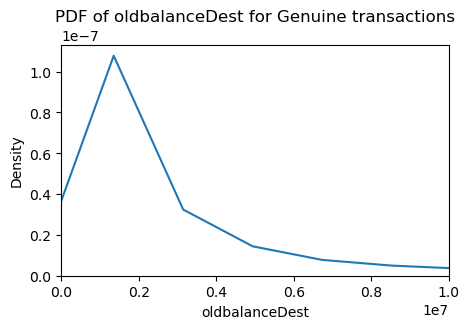

In [65]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_not_fraud_mask], x='oldbalanceDest')
plt.title('PDF of oldbalanceDest for Genuine transactions')
plt.xlim([-1000,10000000])
plt.show()

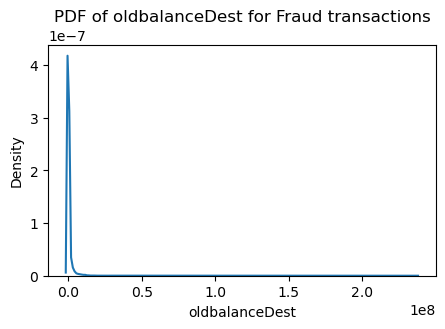

In [66]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_fraud_mask], x='oldbalanceDest')
plt.title('PDF of oldbalanceDest for Fraud transactions')
plt.show()

### The distribution for 'oldbalanceDest' is not normally distributed.

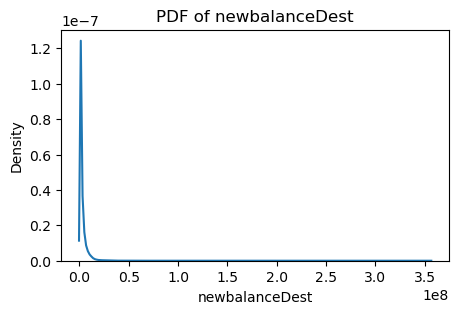

In [67]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2['newbalanceDest'])
plt.title('PDF of newbalanceDest')
plt.show()

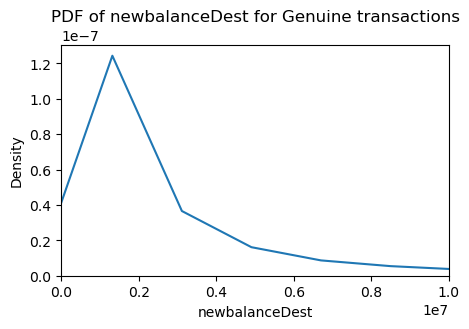

In [68]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_not_fraud_mask], x='newbalanceDest')
plt.title('PDF of newbalanceDest for Genuine transactions')
plt.xlim([-1000,10000000])
plt.show()

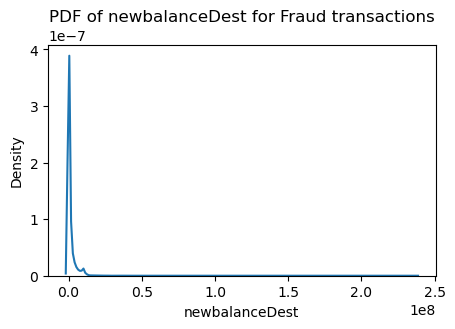

In [69]:
plt.figure(figsize=(5,3))
sns.kdeplot(df2[is_fraud_mask], x='newbalanceDest')
plt.title('PDF of newbalanceDest for Fraud transactions')
plt.show()

### The distribution for 'newbalanceDest' is not normally distributed.

In [70]:
cols_to_remove_2 = ['step', 'err_in_bal_org', 'err_in_bal_dest']
df3 = df2.drop(columns=cols_to_remove_2)

In [71]:
df3

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_CM_T,hour_of_day
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,1,1
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,1,1
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,1
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,1
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,23
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,23
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,23
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,23


In [72]:
df4 = pd.get_dummies(df3, columns=['type'], drop_first=True, dtype=int)
print(df4.shape)
df4.head()

(6362620, 12)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,is_CM_T,hour_of_day,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,1,1,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,1,1,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,0,1,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,0,1,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,1,1,0,0,1,0


### Separate the dependent and independent variables:

In [73]:
feature_variable_names = [col_name for col_name in df4.columns.values if col_name != 'isFraud']
feature_variable_names

['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'is_CM_T',
 'hour_of_day',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER']

In [74]:
X = df4[feature_variable_names]
y = df4[['isFraud']]

print(X.shape)
print(y.shape)

(6362620, 11)
(6362620, 1)


In [75]:
y.value_counts()

isFraud
0          6354407
1             8213
Name: count, dtype: int64

### Splitting the data into train and test:

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(4771965, 11)
(1590655, 11)
(4771965, 1)
(1590655, 1)


In [78]:
y_train.value_counts()

isFraud
0          4765805
1             6160
Name: count, dtype: int64

In [79]:
y_train.value_counts(normalize=True)

isFraud
0          0.998709
1          0.001291
Name: proportion, dtype: float64

In [80]:
y_test.value_counts()

isFraud
0          1588602
1             2053
Name: count, dtype: int64

In [81]:
y_test.value_counts(normalize=True)

isFraud
0          0.998709
1          0.001291
Name: proportion, dtype: float64

In [82]:
from imblearn.over_sampling import SMOTE

In [83]:
smote = SMOTE(random_state=42)

# Creating synthetic samples for minority class to handle data imbalance.
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [84]:
y_train_resampled.value_counts()

isFraud
0          4765805
1          4765805
Name: count, dtype: int64

### Feature Scaling:

In [85]:
from sklearn.preprocessing import StandardScaler

In [86]:
sc = StandardScaler()
sc

StandardScaler()

In [87]:
numerical_col_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                       'newbalanceDest', 'hour_of_day']
X_train_resampled_numerical = X_train_resampled[numerical_col_names]
X_test_numerical = X_test[numerical_col_names]

In [88]:
sc_X_train_resampled_numerical = pd.DataFrame(sc.fit_transform(X_train_resampled_numerical), 
                                    columns=X_train_resampled_numerical.columns, 
                                    index=X_train_resampled_numerical.index)
sc_X_test_numerical = pd.DataFrame(sc.transform(X_test_numerical), 
                                   columns=X_test_numerical.columns,
                                   index=X_test_numerical.index)

In [89]:
sc_X_train_resampled_numerical.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour_of_day
count,9.531610e+06,9.531610e+06,9.531610e+06,9.531610e+06,9.531610e+06,9.531610e+06
mean,1.574410e-18,4.193179e-16,3.736361e-16,1.366755e-16,-1.696915e-16,-1.671260e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.420213e-01,-3.801114e-01,-2.085385e-01,-2.608949e-01,-3.470146e-01,-2.412995e+00
25%,-4.218874e-01,-3.768577e-01,-2.085385e-01,-2.608949e-01,-3.470146e-01,-5.793190e-01
50%,-3.495696e-01,-3.435397e-01,-2.085385e-01,-2.608949e-01,-3.123898e-01,1.541514e-01
75%,-1.502317e-01,-1.348851e-01,-2.085385e-01,-9.917847e-02,-4.316985e-02,8.876219e-01
max,4.929353e+01,1.787004e+01,1.945329e+01,1.131066e+02,9.950677e+01,1.804460e+00


In [90]:
categorical_col_names = [col_name for col_name in feature_variable_names if col_name not in numerical_col_names]

sc_X_train_resampled = pd.concat([sc_X_train_resampled_numerical, X_train_resampled[categorical_col_names]], axis=1)
sc_X_test = pd.concat([sc_X_test_numerical, X_test[categorical_col_names]], axis=1)

In [91]:
categorical_col_names

['is_CM_T', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

In [92]:
X_train_numerical = X_train[numerical_col_names]

sc_X_train_numerical = pd.DataFrame(sc.fit_transform(X_train_numerical), 
                                    columns=X_train_numerical.columns, 
                                    index=X_train_numerical.index)
sc_X_train= pd.concat([sc_X_train_numerical, X_train[categorical_col_names]], axis=1)

print(sc_X_train.shape)

(4771965, 11)


### Building the Logistic Regression model:

In [93]:
from sklearn.linear_model import LogisticRegression

In [94]:
logistic_regression = LogisticRegression(random_state=42)

logistic_regression.fit(sc_X_train_resampled, y_train_resampled.iloc[:, 0])

y_pred_train_logistic = logistic_regression.predict(sc_X_train_resampled)
y_pred_test_logistic = logistic_regression.predict(sc_X_test)

In [95]:
print('Logistic Regression model')

print('Classification report for Train data:')
print(classification_report(y_train_resampled, y_pred_train_logistic))

print("*"*80)

print('Classification report for Test data:')
print(classification_report(y_test, y_pred_test_logistic))

print('Confusion matrix for Train data:')
print(confusion_matrix(y_train_resampled, y_pred_train_logistic))

print('Confusion matrix for Test data:')
print(confusion_matrix(y_test, y_pred_test_logistic))

Logistic Regression model
Classification report for Train data:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96   4765805
           1       0.96      0.96      0.96   4765805

    accuracy                           0.96   9531610
   macro avg       0.96      0.96      0.96   9531610
weighted avg       0.96      0.96      0.96   9531610

********************************************************************************
Classification report for Test data:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588602
           1       0.03      0.94      0.05      2053

    accuracy                           0.96   1590655
   macro avg       0.51      0.95      0.52   1590655
weighted avg       1.00      0.96      0.98   1590655

Confusion matrix for Train data:
[[4559649  206156]
 [ 213565 4552240]]
Confusion matrix for Test data:
[[1519819   68783]
 [    122    1931]]


In [96]:
accuracy_logistic_regression = cross_val_score(logistic_regression, sc_X_train_resampled, 
                                               y_train_resampled.values.ravel(), cv=5)
print(f'Cross validation accuracy for the Logistic Regression based model: {accuracy_logistic_regression.mean()}')

Cross validation accuracy for the Logistic Regression based model: 0.9559461622957717


In [97]:
from sklearn.tree import DecisionTreeClassifier

In [98]:
decision_tree = DecisionTreeClassifier(random_state=42)

decision_tree.fit(sc_X_train_resampled, y_train_resampled.iloc[:, 0])

y_pred_train_dt = decision_tree.predict(sc_X_train_resampled)
y_pred_test_dt = decision_tree.predict(sc_X_test)

In [99]:
print('Decision Tree model')

print('Classification report for Train data:')
print(classification_report(y_train_resampled, y_pred_train_dt))

print("*"*80)

print('Classification report for Test data:')
print(classification_report(y_test, y_pred_test_dt))

print('Confusion matrix for Train data:')
print(confusion_matrix(y_train_resampled, y_pred_train_dt))

print('Confusion matrix for Test data:')
print(confusion_matrix(y_test, y_pred_test_dt))

Decision Tree model
Classification report for Train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4765805
           1       1.00      1.00      1.00   4765805

    accuracy                           1.00   9531610
   macro avg       1.00      1.00      1.00   9531610
weighted avg       1.00      1.00      1.00   9531610

********************************************************************************
Classification report for Test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.69      0.95      0.80      2053

    accuracy                           1.00   1590655
   macro avg       0.85      0.98      0.90   1590655
weighted avg       1.00      1.00      1.00   1590655

Confusion matrix for Train data:
[[4765805       0]
 [      0 4765805]]
Confusion matrix for Test data:
[[1587733     869]
 [     94    1959]]


In [100]:
accuracy_decision_tree = cross_val_score(decision_tree, sc_X_train_resampled, 
                                               y_train_resampled.values.ravel(), cv=5)
print(f'Cross validation accuracy for the Decision Tree based model: {accuracy_decision_tree.mean()}')

Cross validation accuracy for the Decision Tree based model: 0.999598388939539


In [101]:
from xgboost import XGBClassifier

In [102]:
xg_boost = XGBClassifier(seed=42)
xg_boost.fit(sc_X_train_resampled, y_train_resampled.iloc[:, 0])

y_pred_train_xb = xg_boost.predict(sc_X_train_resampled)
y_pred_test_xb = xg_boost.predict(sc_X_test)

In [103]:
print('XGBoost model')

print('Classification report for Train data:')
print(classification_report(y_train_resampled, y_pred_train_xb))

print("*"*80)

print('Classification report for Test data:')
print(classification_report(y_test, y_pred_test_xb))

print('Confusion matrix for Train data:')
print(confusion_matrix(y_train_resampled, y_pred_train_xb))

print('Confusion matrix for Test data:')
print(confusion_matrix(y_test, y_pred_test_xb))

XGBoost model
Classification report for Train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4765805
           1       1.00      1.00      1.00   4765805

    accuracy                           1.00   9531610
   macro avg       1.00      1.00      1.00   9531610
weighted avg       1.00      1.00      1.00   9531610

********************************************************************************
Classification report for Test data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.36      0.99      0.53      2053

    accuracy                           1.00   1590655
   macro avg       0.68      0.99      0.76   1590655
weighted avg       1.00      1.00      1.00   1590655

Confusion matrix for Train data:
[[4755189   10616]
 [   4653 4761152]]
Confusion matrix for Test data:
[[1585002    3600]
 [     23    2030]]


In [104]:
accuracy_xgboost = cross_val_score(xg_boost, sc_X_train_resampled, 
                                               y_train_resampled.values.ravel(), cv=5)
print(f'Cross validation accuracy for the XGBOOST based model: {accuracy_xgboost.mean()}')

Cross validation accuracy for the XGBOOST based model: 0.9983476033954389


In [105]:
from sklearn.ensemble import IsolationForest

In [106]:
isolation_forest = IsolationForest(contamination=0.013, random_state=42)

isolation_forest.fit(sc_X_train)

# Predict the anomaly score
y_pred_train_if = isolation_forest.predict(sc_X_train)
y_pred_test_if = isolation_forest.predict(sc_X_test)

offset_if = isolation_forest.offset_

In [107]:
np.unique(y_pred_train_if)

array([-1,  1])

In [108]:
y_pred_train_if = np.where(y_pred_train_if == -1, 1, 0)
y_pred_test_if = np.where(y_pred_test_if == -1, 1, 0)

In [109]:
print('Isolation Forest model')

print('Classification report for Train data:')
print(classification_report(y_train, y_pred_train_if))

print("*"*80)

print('Classification report for Test data:')
print(classification_report(y_test, y_pred_test_if))

print('Confusion matrix for Train data:')
print(confusion_matrix(y_train, y_pred_train_if))

print('Confusion matrix for Test data:')
print(confusion_matrix(y_test, y_pred_test_if))

Isolation Forest model
Classification report for Train data:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   4765805
           1       0.01      0.08      0.01      6160

    accuracy                           0.99   4771965
   macro avg       0.50      0.53      0.50   4771965
weighted avg       1.00      0.99      0.99   4771965

********************************************************************************
Classification report for Test data:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1588602
           1       0.01      0.07      0.01      2053

    accuracy                           0.98   1590655
   macro avg       0.50      0.53      0.50   1590655
weighted avg       1.00      0.98      0.99   1590655

Confusion matrix for Train data:
[[4704258   61547]
 [   5671     489]]
Confusion matrix for Test data:
[[1565787   22815]
 [   1917     136]]


In [110]:
# Anomaly score returned by sklearn IsolationForest decision_function() is (0.5 - scores) 
# where scores is the Anomaly score as per the original IsolationForest paper.
# https://github.com/scikit-learn/scikit-learn/blob/5491dc695/sklearn/ensemble/_iforest.py#L357
# https://stats.stackexchange.com/questions/335274/scikit-learn-isolationforest-anomaly-score

anomaly_score_train_if = (isolation_forest.decision_function(sc_X_train) * -1 - 
                          isolation_forest.offset_)
anomaly_score_test_if = (isolation_forest.decision_function(sc_X_test) * -1 - 
                         isolation_forest.offset_)

print(anomaly_score_train_if.shape)
print(anomaly_score_test_if.shape)

(4771965,)
(1590655,)


In [111]:
print((anomaly_score_train_if < -1*offset_if).sum())
print((anomaly_score_train_if == -1*offset_if).sum())
print((anomaly_score_train_if > -1*offset_if).sum())

4709929
0
62036


In [112]:
print(f'Train threshold for anomaly detection:  {-1*offset_if}')

Train threshold for anomaly detection:  0.6301001936111721


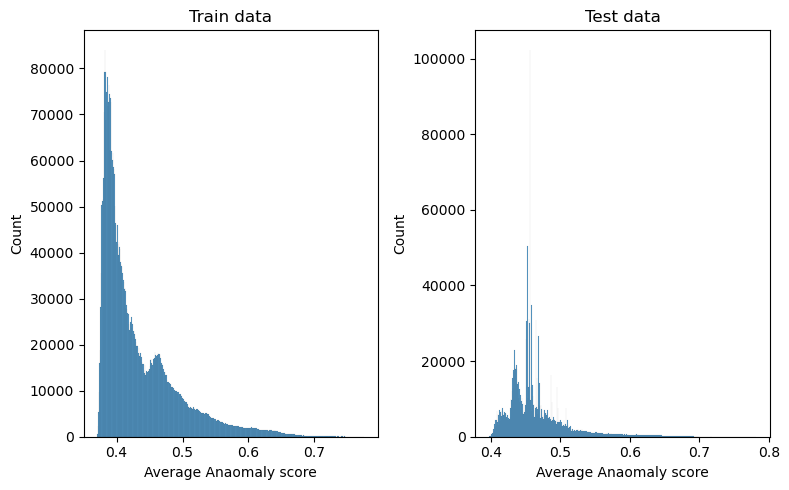

In [113]:
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
sns.histplot(anomaly_score_train_if)
plt.title('Train data')
plt.xlabel('Average Anaomaly score')

plt.subplot(1,2,2)
sns.histplot(anomaly_score_test_if)

plt.title('Test data')
plt.xlabel('Average Anaomaly score')

plt.tight_layout()

plt.show()

In [114]:
decision_tree.feature_importances_

array([1.49702212e-01, 3.48692265e-01, 3.65942600e-01, 3.37482085e-03,
       2.98675947e-02, 4.62684232e-02, 1.77459979e-02, 1.14579898e-02,
       6.06504290e-04, 2.28385931e-04, 2.61132065e-02])

In [115]:
decision_tree.feature_names_in_

array(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'hour_of_day', 'is_CM_T', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'], dtype=object)

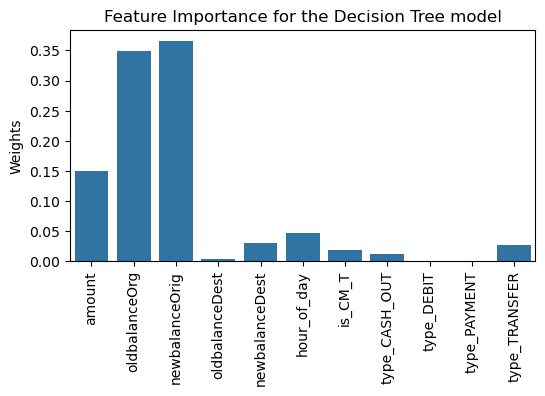

In [116]:
plt.figure(figsize=(6,3))
sns.barplot(x=decision_tree.feature_names_in_, y=decision_tree.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature Importance for the Decision Tree model')
plt.ylabel('Weights')
plt.show()

### Conclusion:

The Decision Tree model is best suited for this task of detecting transactions involving Money Laundering because it
has the least False Positives among all the tried models and a very good precision and recall for the positive and 
negative class in both train and test dataset.

**Train data:**
- Precision for +ve class: 1.0
- Precision for -ve class: 1.0

- Recall for +ve class: 1.0
- Recall for -ve class: 1.0

- Accuracy: 1.0

**Test data:**
- Precision for +ve class: 0.69
- Precision for -ve class: 1.0

- Recall for +ve class: 0.95
- Recall for -ve class: 1.0

- Accuracy: 1.0